In [ ]:
!pip install numpy tensorflow keras tensorflow-model-optimization opencv-python scikit-learn


##CODE

In [ ]:
# Install Dependencies
!pip install keras -q
!pip install tensorflow -q
# !pip install tensorflow-addons -q
!pip install -q tensorflow-model-optimization -q
!pip install -U tensorflow-model-optimization -q
!pip install opencv-python -q
!pip install scikit-learn -q
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-model-optimization 0.8.0 requires numpy~=1.23, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires

In [ ]:
import time

# Get the current time
current_time = time.time()
print("time", current_time)

# ... (other code) ...

# Get the current time again
current_time1 = time.time()
print("time", current_time1)

time 1755925306.9179695
time 1755925306.9181442


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import essential libraries
import numpy as np
import tensorflow as tf
import os
import cv2
import time
import re
import matplotlib.pyplot as plt
import keras

# Keras
from keras import layers
from keras import layers, models, regularizers, optimizers, losses

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting the path for the dataset and model
path="/content/drive/MyDrive/drone_vit/drone_dataset"
model_path="/content/drive/MyDrive/drone_vit/Model"

# Defining hyperparameters
num_classes = 2
input_shape = (299, 299, 3)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 30
batch_size = 32
batch_testsize = 28
image_size = 128         					# We will resize the input images to this size
patch_size = 8           					# Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2							# number of attention heads
transformer_units = [projection_dim * 2, projection_dim,]        # Size of the transformer layers
transformer_layers = 1						# number of transformer layers
mlp_head_units = [2048, 1024]                                    # Size of the dense layers of the final classifier
key_dim = projection_dim // num_heads

# Creating the datasets
X = []
y = []
Files = ['drone', 'no drone']
label_val = 0

for files in Files:
    cpath = os.path.join(path, files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        X.append(image_array)
        y.append(label_val)
    label_val = 1


X = np.array(X) # Normalize images
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

# Steps per epoch
STEP_SIZE_TRAIN = int(np.ceil(len(X_train) / batch_size))
STEP_SIZE_VALID = int(np.ceil(len(X_val) / batch_size))
STEP_SIZE_TEST = int(np.ceil(len(X_test) / batch_testsize))

In [ ]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.Resizing(image_size, image_size)
])

# MLP function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])

# Patch Encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=num_patches, delta=1)
        return self.projection(patches) + self.position_embedding(positions)

# Vision Transformer Model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape,dtype="uint8")
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim,use_bias=False
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, dropout_rate=0.0)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.0)(representation)
    features = mlp(representation, mlp_head_units, dropout_rate=0.0)
    logits = layers.Dense(num_classes)(features)
    return keras.Model(inputs=inputs, outputs=logits)

# Training and Evaluation
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    checkpoint_filepath = "/content/drive/MyDrive/Project/ViT/Checkpoint/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
         filepath=checkpoint_filepath,
         monitor="val_accuracy",
         save_best_only=True,
         save_weights_only=True
    )

    history = model.fit(
        x=X_train, y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_callback],
        shuffle=True
    )

    model.save(os.path.join(model_path, "ViT_Model.h5"))
    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_testsize)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    y_pred_probs = model.predict(X_test, batch_size=batch_testsize)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["drone", "no drone"]))
    return history

# Create and train model
vit_model = create_vit_classifier()
history = run_experiment(vit_model)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5527 - loss: 15.2437 - val_accuracy: 0.7135 - val_loss: 1.4364
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7709 - loss: 0.5998 - val_accuracy: 0.8596 - val_loss: 1.0703
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7976 - loss: 0.4483 - val_accuracy: 0.8315 - val_loss: 1.0816
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8931 - loss: 0.2696 - val_accuracy: 0.8876 - val_loss: 0.9728
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9341 - loss: 0.1661 - val_accuracy: 0.9101 - val_loss: 1.0106
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9733 - loss: 0.0914 - val_accuracy: 0.9270 - val_loss: 0.9959
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9633 - loss: 0.1056 - val_accuracy: 0.9270 - val_loss: 1.0127
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9915 - loss: 0.0386 - val_accuracy: 0.9213 - val_loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8923 - loss: 0.6430
Test accuracy: 89.39%
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step
Confusion Matrix:
 [[200  25]
 [ 22 196]]
Classification Report:
               precision    recall  f1-score   support

       drone       0.90      0.89      0.89       225
    no drone       0.89      0.90      0.89       218

    accuracy                           0.89       443
   macro avg       0.89      0.89      0.89       443
weighted avg       0.89      0.89      0.89       443



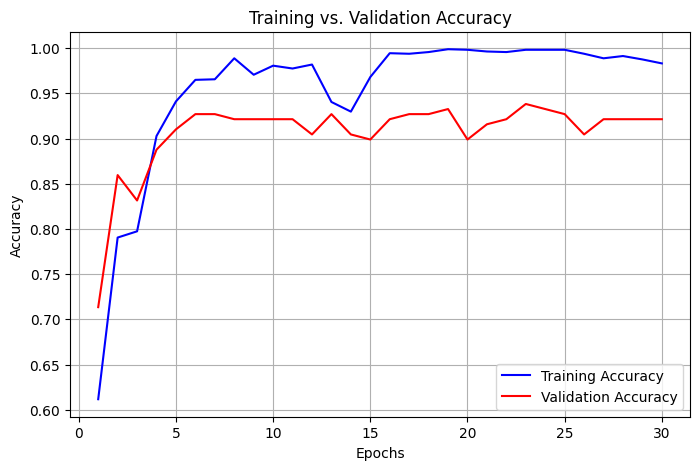

In [ ]:
import matplotlib.pyplot as plt

# Assuming you trained your model with:
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Extract accuracy and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


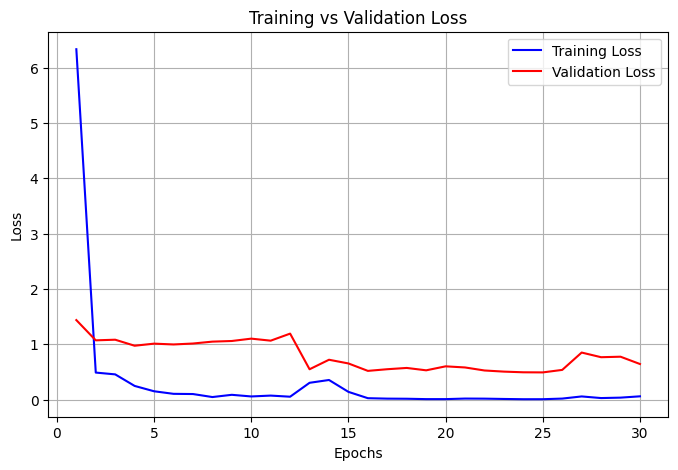

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')  # Blue line for training loss
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')  # Red line for validation loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=8)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.4, random_state=8)

# Making predictions
y_pred = vit_model.predict(X1_test, steps=STEP_SIZE_TEST)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y1_test, y_pred, target_names=["drone", " no drone"]))

# Print confusion matrix
conf_matrix = confusion_matrix(y1_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step
              precision    recall  f1-score   support

       drone       0.95      0.94      0.94       423
    no drone       0.94      0.95      0.95       463

    accuracy                           0.94       886
   macro avg       0.94      0.94      0.94       886
weighted avg       0.94      0.94      0.94       886

Confusion Matrix:
 [[397  26]
 [ 23 440]]


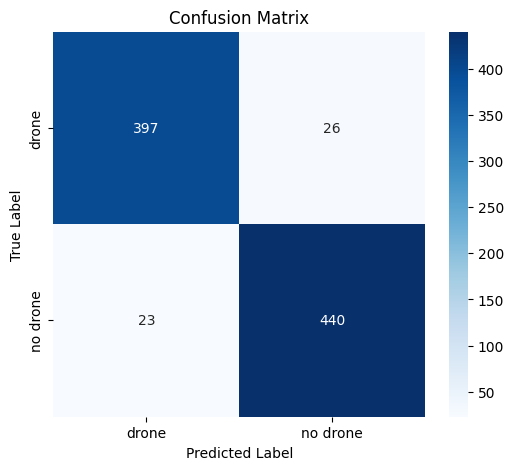

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y1_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["drone", "no drone"], yticklabels=["drone", "no drone"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


##INT_TFLITE

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Path to save quantized TFLite model
tflite_model_path_dynamic = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"

# Create converter from your trained Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(vit_model)

# Enable optimizations for dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]


# Convert the model to dynamic range INT8
tflite_dynamic_model = converter.convert()

# Save model to file
with open(tflite_model_path_dynamic, "wb") as f:
    f.write(tflite_dynamic_model)

print("✅ Dynamic Range INT8 Quantized TFLite model saved at:", tflite_model_path_dynamic)

Saved artifact at '/tmp/tmphtj9x6_u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.uint8, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139615594724816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594725008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594725200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594724240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594723856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594723664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594724432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615594724624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615589515536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139615589516112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1396155895172

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


✅ Model loaded. Input: [{'name': 'serving_default_keras_tensor_39:0', 'index': 0, 'shape': array([  1, 299, 299,   3], dtype=int32), 'shape_signature': array([ -1, 299, 299,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 109, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
📊 TFLite Model Accuracy: 89.39%


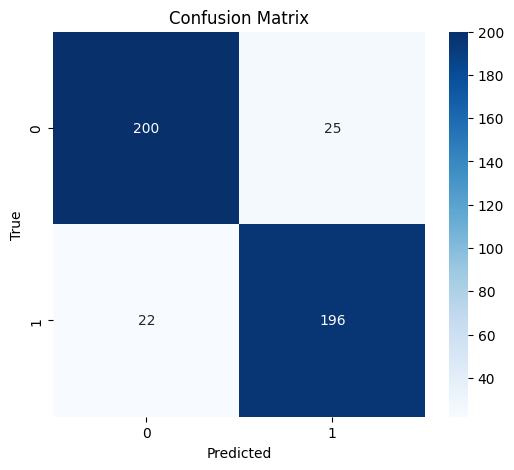

📑 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       225
           1       0.89      0.90      0.89       218

    accuracy                           0.89       443
   macro avg       0.89      0.89      0.89       443
weighted avg       0.89      0.89      0.89       443



In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Path to quantized model
tflite_model_path = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ Model loaded. Input:", input_details, "Output:", output_details)

# Function for batch inference
def tflite_predict_batch(X):
    preds = []
    for i in range(len(X)):
        img = X[i:i+1].astype(np.uint8)  # model expects uint8
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        preds.append(output_data[0])
    return np.array(preds)

# Run inference on test set
y_pred_probs = tflite_predict_batch(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_test)
print(f"📊 TFLite Model Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("📑 Classification Report:")
print(classification_report(y_test, y_pred))


##WE

In [ ]:
# Import essential libraries
import os, re, time
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Mount Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

tflite_model_path = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"

dataset_path   = "/content/drive/MyDrive/drone_vit/drone_dataset"
image_path     = "/content/drive/MyDrive/drone_vit/drone_dataset/no drone/00000463_(5).jpg"


# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Model & data hyperparams
num_classes   = 2
input_hwc     = (299, 299, 3)   # TFLite model input
class_names   = ["drone", "No drone"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X, y = [], []
labels = ['drone', 'no drone']

for label_idx, label_name in enumerate(labels):
    cpath = os.path.join(dataset_path, label_name)
    for fname in os.listdir(cpath):
        fpath = os.path.join(cpath, fname)
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (input_hwc[1], input_hwc[0]))  # 299x299
        X.append(img)
        y.append(label_idx)

X = np.asarray(X, dtype=np.uint8)
y = np.asarray(y, dtype=np.int64)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=8)

len(X_train), len(X_val), len(X_test)


(1594, 178, 443)

In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Loaded TFLite model.")
print("Input  :", input_details)
print("Output :", output_details)

# Helper: single-batch predict
def tflite_predict(batch_uint8):
    interpreter.set_tensor(input_details[0]['index'], batch_uint8)
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])  # float32 logits/probs


Loaded TFLite model.
Input  : [{'name': 'serving_default_keras_tensor_39:0', 'index': 0, 'shape': array([  1, 299, 299,   3], dtype=int32), 'shape_signature': array([ -1, 299, 299,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output : [{'name': 'StatefulPartitionedCall_1:0', 'index': 109, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
def preprocess_image(image_path, size=(299, 299)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    img = cv2.resize(img, size)
    img = img.astype(np.uint8)
    return img[None, ...]   # (1, H, W, C)

sample = preprocess_image(image_path)
out = tflite_predict(sample)
print("Raw output:", out)
print("Predicted class:", class_names[int(np.argmax(out, axis=1)[0])])


Raw output: [[-10.215859   8.961383]]
Predicted class: No drone


In [ ]:
import tensorflow as tf
import numpy as np
import os

# Path to quantized model
tflite_model_path = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"

# Output directory
output_dir = "/content/drive/MyDrive/drone_vit/Outputs/tflite_weights"
os.makedirs(output_dir, exist_ok=True)

# Load interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()

print(f"🔎 Found {len(tensor_details)} tensors in TFLite model")

# Extract only constant tensors (these are weights/biases)
for i, tensor in enumerate(tensor_details):
    if "Const" in tensor["name"]:
        weights = interpreter.get_tensor(tensor["index"])

        # Friendly filename
        safe_name = tensor["name"].replace("/", "_").replace(":", "_")
        file_path = os.path.join(output_dir, f"{i}_{safe_name}.txt")

        # Save to txt
        np.savetxt(file_path, weights.flatten(), fmt="%.6f", delimiter=",")
        print(f"✅ Saved: {file_path} | shape={weights.shape}")


🔎 Found 110 tensors in TFLite model


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# import tensorflow as tf
# import numpy as np
# import os

# # ==== Paths ====
# tflite_model_path = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"
# save_dir = "/content/drive/MyDrive/drone_vit/Extracted_Weights_TFLite"
# os.makedirs(save_dir, exist_ok=True)

# # ==== Load TFLite ====
# interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
# interpreter.allocate_tensors()
# tensor_details = interpreter.get_tensor_details()

# print(f"🔎 Found {len(tensor_details)} tensors in TFLite model")

# # ==== Save weights with better names ====
# for i, tensor in enumerate(tensor_details):
#     name = tensor['name']
#     try:
#         arr = interpreter.get_tensor(tensor['index'])
#     except:
#         continue  # skip tensors with no values

#     if arr.size == 0:
#         continue  # skip empty tensors

#     # ----- Rename for readability -----
#     if "embedding" in name.lower():
#         file_name = f"{i:03d}_embedding.txt"
#     elif "dense" in name.lower():
#         file_name = f"{i:03d}_dense.txt"
#     elif "attention" in name.lower() or "qkv" in name.lower():
#         file_name = f"{i:03d}_attention_qkv.txt"
#     elif "norm" in name.lower():
#         file_name = f"{i:03d}_layernorm.txt"
#     else:
#         file_name = f"{i:03d}_{name.replace('/', '_')}.txt"

#     # Save as .txt (float or int depending on quantization)
#     np.savetxt(os.path.join(save_dir, file_name), arr.flatten())
#     print(f"✅ Saved {file_name} | shape={arr.shape} dtype={arr.dtype}")

# print(f"\n📂 All extracted weights saved to: {save_dir}")


In [ ]:
import os
import numpy as np
import tensorflow as tf

# Path to quantized TFLite model
tflite_model_path = "/content/drive/MyDrive/drone_vit/Model/ViT_Model_dynamic_range_INT8.tflite"

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Create folder to save weights
save_dir = "/content/drive/MyDrive/drone_vit/Extracted_Weights"
os.makedirs(save_dir, exist_ok=True)

# Loop through tensors and save weights
for i, detail in enumerate(interpreter.get_tensor_details()):
    name = detail['name'].replace("/", "_").replace(":", "_")
    file_txt = f"tensor_{i}_{name}.txt"
    file_npy = f"tensor_{i}_{name}.npy"

    try:
        arr = interpreter.get_tensor(detail['index'])

        # Save as INT8 text (for mam)
        np.savetxt(os.path.join(save_dir, file_txt), arr.flatten().astype(np.int8), fmt="%d")

        # Save as NPY binary (for you)
        np.save(os.path.join(save_dir, file_npy), arr.astype(np.int8))

        print(f"✅ Saved {file_txt} and {file_npy}")

    except Exception as e:
        print(" ")


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


✅ Saved tensor_0_serving_default_keras_tensor_39_0.txt and tensor_0_serving_default_keras_tensor_39_0.npy
✅ Saved tensor_1_arith.constant.txt and tensor_1_arith.constant.npy
✅ Saved tensor_2_arith.constant1.txt and tensor_2_arith.constant1.npy
✅ Saved tensor_3_arith.constant2.txt and tensor_3_arith.constant2.npy
✅ Saved tensor_4_arith.constant3.txt and tensor_4_arith.constant3.npy
✅ Saved tensor_5_arith.constant4.txt and tensor_5_arith.constant4.npy
✅ Saved tensor_6_arith.constant5.txt and tensor_6_arith.constant5.npy
✅ Saved tensor_7_arith.constant6.txt and tensor_7_arith.constant6.npy
✅ Saved tensor_8_arith.constant7.txt and tensor_8_arith.constant7.npy
✅ Saved tensor_9_arith.constant8.txt and tensor_9_arith.constant8.npy
✅ Saved tensor_10_arith.constant9.txt and tensor_10_arith.constant9.npy
✅ Saved tensor_11_arith.constant10.txt and tensor_11_arith.constant10.npy
✅ Saved tensor_12_arith.constant11.txt and tensor_12_arith.constant11.npy
✅ Saved tensor_13_arith.constant12.txt and ten